# wgcna入门-雌性小鼠肝脏表达数据的网络分析：寻找与体重有关的模块
本文主要参考WGCNA官网的教程1。整个分析流程可以分为以下几个步骤：
1. 数据输入和清理
2. 建设表达网络与模块检测
3. 筛选与表型相关的模块
4. 使用WGCNA进行网络可视化
5. 参考

**WGCNA的安装**
前置软件包安装如果是R语言3.5及以上版本，安装命令如下：
> install.packages("BiocManager")  
> BiocManager::install(c("AnnotationDbi", "impute","GO.db", "preprocessCore"))
> install.packages(c("matrixStats", "Hmisc","foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival"))
> install.packages(c("WGCNA", "stringr", "reshape2"))

如果R语言3.5以下版本，安装命令如下：
> source("https://bioconductor.org/biocLite.R")
> biocLite(c("AnnotationDbi", "impute","GO.db", "preprocessCore"))
> install.packages(c("matrixStats", "Hmisc","foreach", "doParallel", "fastcluster", "dynamicTreeCut", "survival"))
> install.packages(c("WGCNA", "stringr", "reshape2"))

**专有名词**
+ 共表达网络：定义为加权基因网络。点代表基因，边代表基因表达相关性；
+ Module(模块)：高度內连的基因集。在无向网络中，模块内是高度相关的基因。在有向网络中，模块内是高度正相关的基因；
+ 邻接矩阵(Adjacency matrix)：基因和基因之间的加权相关性值构成的矩阵;
+ 软阈值：相关性值进行幂次运算幂次的值也就是软阈值;
+ 连接度(Connectivity)：类似于网络中 "度"degree)的概念。每个基因的连接度是与其相连的基因的边属性之和;

In [1]:
# 加载库
library(WGCNA);

Warning message:
"package 'WGCNA' was built under R version 3.6.1"Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust



Attaching package: 'WGCNA'

The following object is masked from 'package:stats':

    cor



## 1 数据输入和清洗
主要步骤如下：
1. 加载基因表达数据
2. 数据清洗
3. 加载临床特征数据

### 1.1 加载基因表达数据

In [2]:
# 读取文件
# The following setting is important, do not omit.
# 如果没有显式地指定“stringsAsFactors=FALSE”,默认会将所有的字符串转换为因子,导致数据处理速度较慢
options(stringsAsFactors = FALSE)
# Read in the female liver data set 读取135个雌性小鼠的数据
femData = read.csv("./data/LiverFemale3600.csv")
# Take a quick look at what is in the data set:
# 查看数据的维度
dim(femData)
# 预览数据
head(femData)

[1] 3600  143

substanceBXH,gene_symbol,LocusLinkID,ProteomeID,cytogeneticLoc,CHROMOSOME,StartPosition,EndPosition,F2_2,F2_3,...,F2_324,F2_325,F2_326,F2_327,F2_328,F2_329,F2_330,F2_332,F2_355,F2_357
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MMT00000044,1700007N18Rik,69339,286025,0,16,50911260,50912491,-0.01810,0.0642,...,0.047700,-0.0488,0.0168,-0.0309,0.02740,-0.0310,0.0660,-0.0199,-0.0146,0.065000
MMT00000046,Mast2,17776,157466,0,4,115215318,115372404,-0.07730,-0.0297,...,-0.049200,-0.0350,-0.0738,-0.1730,-0.07380,-0.2010,-0.0820,-0.0939,0.0192,-0.049900
MMT00000051,Ankrd32,105377,321939,0,13,74940309,74982847,-0.02260,0.0617,...,0.000612,0.1210,0.0996,0.1090,0.02730,0.1200,-0.0629,-0.0395,0.1090,0.000253
MMT00000076,0,383154,0,0,16,49345114,49477048,-0.00924,-0.1450,...,-0.270000,0.0803,0.0424,0.1610,0.05120,0.2410,0.3890,0.0251,-0.0348,0.114000
MMT00000080,Ldb2,16826,157383,0,5,43546124,43613704,-0.04870,0.0582,...,0.113000,-0.0859,-0.1340,0.0639,0.00731,0.1240,-0.0212,0.0870,0.0512,0.024300
MMT00000102,Rdhs,216453,0,10_70.0_cM,10,1337265,1347607,0.17600,-0.1890,...,-0.080000,-0.1200,0.1230,0.1870,0.05410,0.0699,0.0708,0.1450,-0.0399,0.037500


提供的基因表达数据中，还有额外的冗余数据，需要把多余注释信息去除，代码如下：

In [3]:
#  删除冗余数据-c(1:8)删除前8列数据，t()转置数据
datExpr0 = as.data.frame(t(femData[, -c(1:8)]));
head(datExpr0)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V3591,V3592,V3593,V3594,V3595,V3596,V3597,V3598,V3599,V3600
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2_2,-0.0181000,-0.0773,-0.02260000,-0.00924,-0.04870000,0.17600000,0.07680000,-0.14800000,0.06870000,0.06090000,...,0.0135000,-0.15400000,-0.0218000,0.0310000,0.1290000,0.0467000,0.00991000,0.0291000,-0.00927,0.0436000
F2_3,0.0642000,-0.0297,0.06170000,-0.14500,0.05820000,-0.18900000,0.18600000,0.17700000,0.10100000,0.05570000,...,-0.0097100,-0.07410000,0.0900000,0.0106000,0.1130000,-0.0252000,0.03190000,0.0408000,-0.12100,0.0827000
F2_14,0.0000644,0.1120,-0.12900000,0.02870,-0.04830000,-0.06500000,0.21400000,-0.13200000,0.10900000,0.19100000,...,0.0709000,-0.13900000,0.0277000,-0.1310000,0.2550000,-0.1230000,0.08800000,0.0892000,-0.11400,-0.0872000
F2_15,-0.0580000,-0.0589,0.08710000,-0.04390,-0.03710000,-0.00846000,0.12000000,0.10700000,-0.00858000,-0.12100000,...,-0.0313000,-0.07250000,0.0178000,0.0882000,0.0790000,0.0002760,-0.04820000,0.0493000,-0.05010,-0.0390000
F2_19,0.0483000,0.0443,-0.11500000,0.00425,0.02510000,-0.00574000,0.02100000,-0.11900000,0.10500000,0.05410000,...,0.0695000,-0.11500000,0.0618000,0.2950000,0.1270000,-0.0560000,-0.02890000,-0.0389000,0.00718,0.0710000
F2_20,-0.1519741,-0.0938,-0.06502607,-0.23610,0.08504274,-0.01807182,0.06222751,-0.05497686,-0.02441415,0.06343181,...,0.1743492,-0.09405315,0.1176646,0.1161963,0.1180381,-0.1171272,-0.09774204,-0.0745188,0.31857,0.2047701


In [4]:
# 将原数据的行列名复制过来
names(datExpr0) = femData$substanceBXH;
rownames(datExpr0) = names(femData)[-c(1:8)];
head(datExpr0)

,MMT00000044,MMT00000046,MMT00000051,MMT00000076,MMT00000080,MMT00000102,MMT00000149,MMT00000159,MMT00000207,MMT00000212,...,MMT00082822,MMT00082828,MMT00082829,MMT00082832,MMT00082847,MMT00082850,MMT00082869,MMT00082877,MMT00082899,MMT00082906
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2_2,-0.0181000,-0.0773,-0.02260000,-0.00924,-0.04870000,0.17600000,0.07680000,-0.14800000,0.06870000,0.06090000,...,0.0135000,-0.15400000,-0.0218000,0.0310000,0.1290000,0.0467000,0.00991000,0.0291000,-0.00927,0.0436000
F2_3,0.0642000,-0.0297,0.06170000,-0.14500,0.05820000,-0.18900000,0.18600000,0.17700000,0.10100000,0.05570000,...,-0.0097100,-0.07410000,0.0900000,0.0106000,0.1130000,-0.0252000,0.03190000,0.0408000,-0.12100,0.0827000
F2_14,0.0000644,0.1120,-0.12900000,0.02870,-0.04830000,-0.06500000,0.21400000,-0.13200000,0.10900000,0.19100000,...,0.0709000,-0.13900000,0.0277000,-0.1310000,0.2550000,-0.1230000,0.08800000,0.0892000,-0.11400,-0.0872000
F2_15,-0.0580000,-0.0589,0.08710000,-0.04390,-0.03710000,-0.00846000,0.12000000,0.10700000,-0.00858000,-0.12100000,...,-0.0313000,-0.07250000,0.0178000,0.0882000,0.0790000,0.0002760,-0.04820000,0.0493000,-0.05010,-0.0390000
F2_19,0.0483000,0.0443,-0.11500000,0.00425,0.02510000,-0.00574000,0.02100000,-0.11900000,0.10500000,0.05410000,...,0.0695000,-0.11500000,0.0618000,0.2950000,0.1270000,-0.0560000,-0.02890000,-0.0389000,0.00718,0.0710000
F2_20,-0.1519741,-0.0938,-0.06502607,-0.23610,0.08504274,-0.01807182,0.06222751,-0.05497686,-0.02441415,0.06343181,...,0.1743492,-0.09405315,0.1176646,0.1161963,0.1180381,-0.1171272,-0.09774204,-0.0745188,0.31857,0.2047701


### 1.2 数据清洗  
我们首先检查缺失值过多的基因和样本，通过goodSamplesGenes检查缺失值，verbose详细程度。

In [5]:
gsg = goodSamplesGenes(datExpr0, verbose = 3)
gsg$allOK;

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

如果样本检查语句返回TRUE，那么没有缺失值。如果不是的话，我们会移除那些有问题的基因和样本。通过以下代码来移除缺失值

In [6]:
if (!gsg$allOK)
{
    # Optionally, print the gene and sample names that were removed:
    # 打印删除的基因和样本名称
    if (sum(!gsg$goodGenes)>0)
        printFlush(paste("Removing genes:", paste(names(datExpr0)[!gsg$goodGenes], collapse = ", ")));
    if (sum(!gsg$goodSamples)>0)
        printFlush(paste("Removing samples:", paste(rownames(datExpr0)[!gsg$goodSamples], collapse = ", ")));
    # Remove the offending genes and samples from the data:
    # 从数据中删除有问题的基因和样本
    datExpr0 = datExpr0[gsg$goodSamples, gsg$goodGenes]
}

接下来我们对样本进行聚类（与随后的基因聚类相比），看看是否有明显的异常值。

In [7]:
# hclusts聚类算法, dist计算基因之间的距离
sampleTree = hclust(dist(datExpr0), method = "average");
# Plot the sample tree: Open a graphic output window of size 12 by 9 inches
# The user should change the dimensions if the window is too large or too small.
# 绘制聚类树，sizeGrWindow设置绘图窗口大小
# sizeGrWindow(16,9)
pdf(file = "./plot/sampleClustering.pdf", width = 12, height = 9);
# 设置文字大小
par(cex = 0.5);
# 设置图像边距c(bottom, left, top, right) 
# par(mar = c(0,4,2,0))
# 画图 main标题，sub子标题，xlab x轴标题，cex.lab标题字体大小，cex.axis坐标轴刻度大小，cex.main主标题字体
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)
dev.off()

png 
  2

由上图图能够看出，F2_221 这个样本和其他样本差距非常大，需要将该样本过滤掉。过滤代码如下

clust
  0   1 
  1 134 

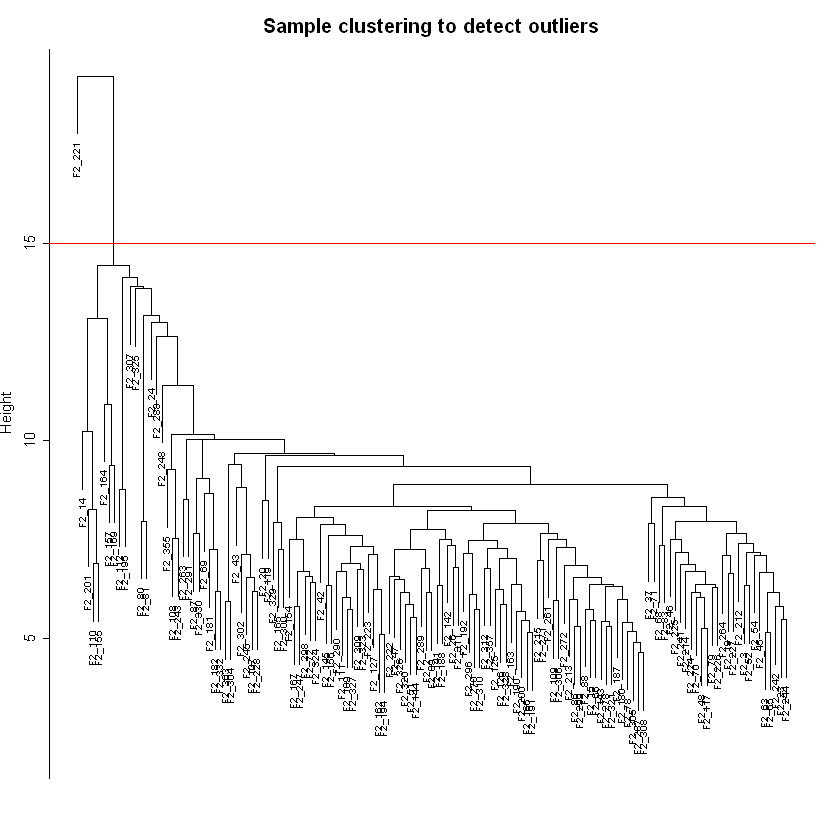

In [8]:
# Plot a line to show the cut
# 设置文字大小
par(cex = 0.5);
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex.lab = 1.5, cex.axis = 1.5, cex.main = 2)
# 在上图上画红线
abline(h = 15, col = "red");
# Determine cluster under the line
# 剪枝算法，cutHeight 修剪树枝的高度 minSize集群最小数
clust = cutreeStatic(sampleTree, cutHeight = 15, minSize = 10)
# 剪枝结果
table(clust)
# clust 1 contains the samples we want to keep
keepSamples = (clust==1)
# 符合要求的数据
datExpr = datExpr0[keepSamples, ]
# 提取行
nSamples = nrow(datExpr)
# 提取列
nGenes = ncol(datExpr)

### 1.3 加载临床特征数据  
我们现在读取性状数据，并将测量它们的样本与表达样本相匹配。

In [9]:
traitData = read.csv("./data/ClinicalTraits.csv");
dim(traitData)
#names(traitData)
# remove columns that hold information we do not need.
# 删除不需要的列
allTraits = traitData[, -c(31, 16)];
allTraits = allTraits[, c(2, 11:36) ];
dim(allTraits)
head(allTraits)
# names(allTraits)

[1] 361  38

[1] 361  27

Mice,weight_g,length_cm,ab_fat,other_fat,total_fat,X100xfat_weight,Trigly,Total_Chol,HDL_Chol,...,Leptin_pg_ml,Adiponectin,Aortic.lesions,Aneurysm,Aortic_cal_M,Aortic_cal_L,CoronaryArtery_Cal,Myocardial_cal,BMD_all_limbs,BMD_femurs_only
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
F2_290,36.9,9.9,2.53,2.26,4.79,12.981030,53,1167,50,...,245462.00,11.274,496250,16,0,17,0,0,NA,NA
F2_291,48.5,10.7,2.90,2.97,5.87,12.103093,61,1230,32,...,84420.88,7.099,NA,16,4,0,2,4,0.0548,0.07730
F2_292,45.7,10.4,1.04,2.31,3.35,7.330416,41,1285,81,...,105889.76,5.795,218500,0,0,11,0,0,0.0554,0.08065
F2_293,50.3,10.9,0.91,1.89,2.80,5.566600,271,1299,64,...,100398.68,5.495,61250,0,0,0,0,236,0.0597,0.08680
F2_294,44.8,9.8,1.22,2.47,3.69,8.236607,114,1410,50,...,130846.30,6.868,243750,12,10,0,0,0,NA,NA
F2_295,39.2,10.2,3.06,2.49,5.55,14.158163,72,1533,18,...,75166.22,17.328,104250,17,2,0,0,0,0.0557,0.07700


In [10]:
# 形成一个类似于表达数据的数据框架，以保存临床特征
# 提取行名
femaleSamples = rownames(datExpr)
# 数据匹配 返回匹配行
traitRows = match(femaleSamples, allTraits$Mice);
# 提取指定要求行
datTraits = allTraits[traitRows, -1];
# 提取行名
rownames(datTraits) = allTraits[traitRows, 1];
# 垃圾回收
collectGarbage();

现在我们有了变量datExpr中的表达式数据，以及变量dattitries中相应的临床特征。在我们继续进行网络构建和模块检测之前，我们将可视化临床特征与样本树状图的关系。

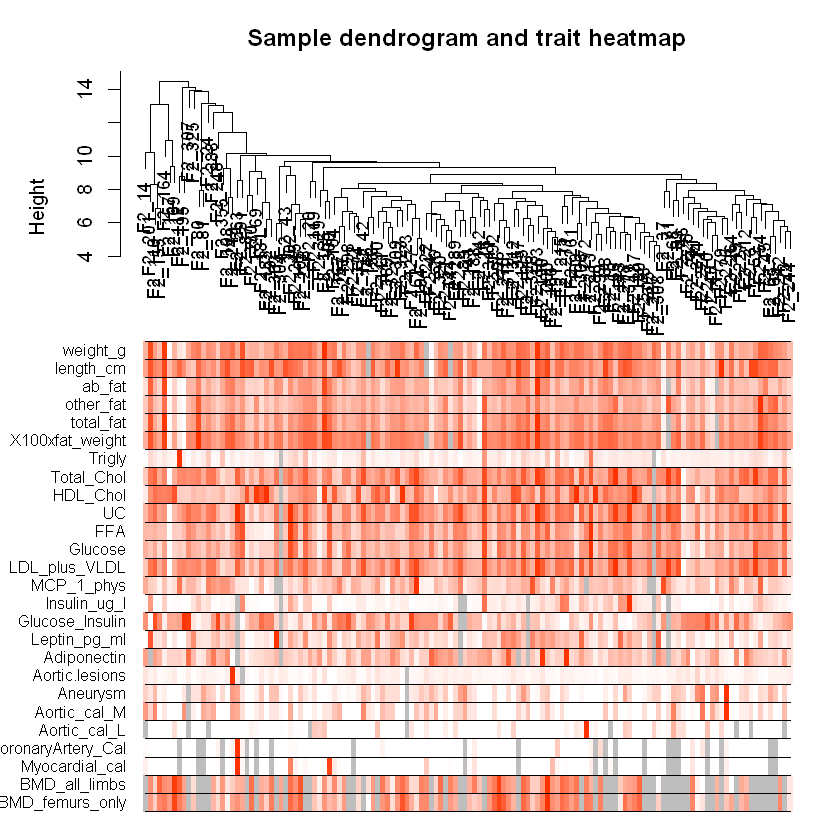

In [11]:
# Re-cluster samples
# 画聚类图
sampleTree2 = hclust(dist(datExpr), method = "average")
# Convert traits to a color representation: white means low, red means high, grey means missing entry
# 画表型的热图
# 将特征转换为颜色表示：白色表示低，红色表示高，灰色表示缺少条目
# 如果signed为true 以绿色开头代表最大负值，以白色开头代表零附近的值，然后变为红色代表正值
traitColors = numbers2colors(datTraits, signed =FALSE);
# Plot the sample dendrogram and the colors underneath.
# 绘制出树状图和下面的颜色 
plotDendroAndColors(sampleTree2, traitColors,groupLabels = names(datTraits),main = "Sample dendrogram and trait heatmap")

## 2 建设表达网络与模块检测
此步骤是使用WGCNA方法进行所有网络分析的基础。我们提出三种不同的方法构建网络并识别模块：
+ 使用方便的一步网络结构和模块检测功能，适合希望以最小努力达到结果的用户；
+ 为希望使用定制/替代方法进行实验的用户逐步构建网络和模块检测；
+ 一种自动分块网络结构和模块检测方法，适用于希望分析太大而无法同时分析的数据集的用户。

主要步骤如下：  
1. 自动一步构建网络与模块检测
2. 其他检测算法

### 2.1 自动一步构建网络与模块检测
在本教程中，我们将演示一步式自动网络构建和模块检测，主要步骤有：
1. 软阈值的选择：网络拓扑分析
2. 一步构建网络与模块检测

#### 2.1.1 软阈值的选择：网络拓扑分析

构建一个加权基因网络需要选择软阈值幂β来计算邻接矩阵权重参数,即将基因间的相关系数进行乘方运算来表征其相关性，首先需要确定乘方的值

In [12]:
# Choose a set of soft-thresholding powers
# 给出候选的β值，c(1:10)表示1到10；seq(from = 12, to=20, by=2)表示从12开始间隔两个数到20
powers = c(c(1:10), seq(from = 12, to=20, by=2))
powers
# Call the network topology analysis function 调用网络拓扑分析函数
# verbose表示输出结果详细程度
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 0);

[1]  1  2  3  4  5  6  7  8  9 10 12 14 16 18 20

Warning message:
"executing %dopar% sequentially: no parallel backend registered"

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0278  0.345          0.456  747.00  762.0000 1210.0
2      2   0.1260 -0.597          0.843  254.00  251.0000  574.0
3      3   0.3400 -1.030          0.972  111.00  102.0000  324.0
4      4   0.5060 -1.420          0.973   56.50   47.2000  202.0
5      5   0.6810 -1.720          0.940   32.20   25.1000  134.0
6      6   0.9020 -1.500          0.962   19.90   14.5000   94.8
7      7   0.9210 -1.670          0.917   13.20    8.6800   84.1
8      8   0.9040 -1.720          0.876    9.25    5.3900   76.3
9      9   0.8590 -1.700          0.836    6.80    3.5600   70.5
10    10   0.8330 -1.660          0.831    5.19    2.3800   65.8
11    12   0.8530 -1.480          0.911    3.33    1.1500   58.1
12    14   0.8760 -1.380          0.949    2.35    0.5740   51.9
13    16   0.9070 -1.300          0.970    1.77    0.3090   46.8
14    18   0.9120 -1.240          0.973    1.39    0.1670   42.5
15    20   0.9310 -1.210 

In [13]:
# sft这中保存了每个powers值计算出来的网络特征,其中powerEstimate就是最佳power值，fitIndices保存了每个power对应的网络的特征。
str(sft)

List of 2
 $ powerEstimate: num 6
 $ fitIndices   :'data.frame':	15 obs. of  7 variables:
  ..$ Power         : num [1:15] 1 2 3 4 5 6 7 8 9 10 ...
  ..$ SFT.R.sq      : num [1:15] 0.0278 0.1264 0.3404 0.5062 0.6807 ...
  ..$ slope         : num [1:15] 0.345 -0.597 -1.03 -1.422 -1.716 ...
  ..$ truncated.R.sq: num [1:15] 0.456 0.843 0.972 0.973 0.94 ...
  ..$ mean.k.       : num [1:15] 747 254.5 111 56.5 32.2 ...
  ..$ median.k.     : num [1:15] 761.7 250.8 101.7 47.2 25.1 ...
  ..$ max.k.        : num [1:15] 1206 574 324 202 134 ...


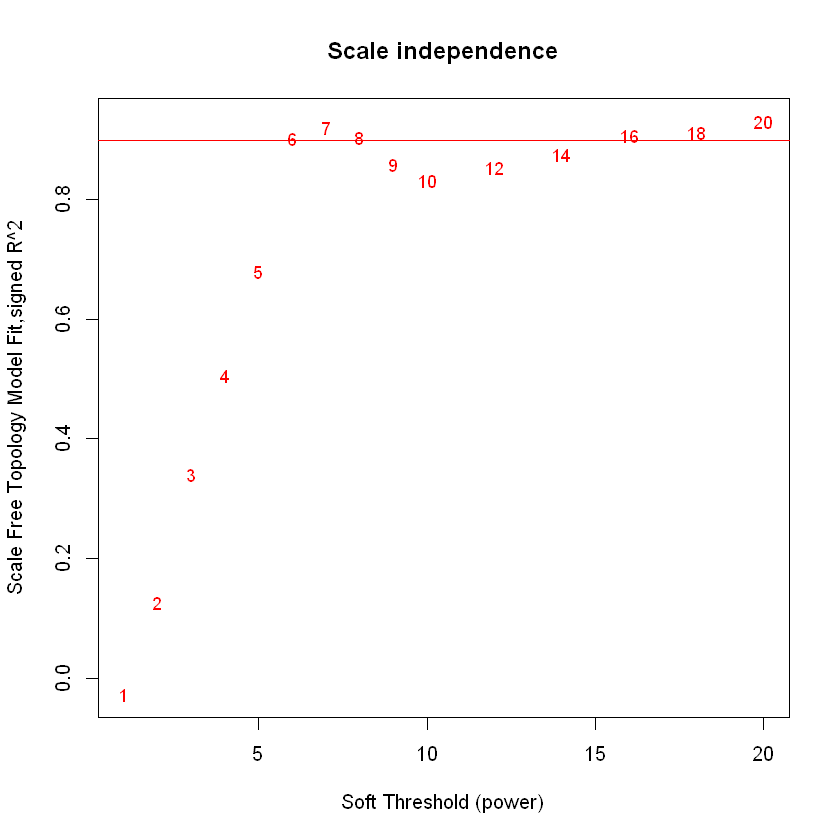

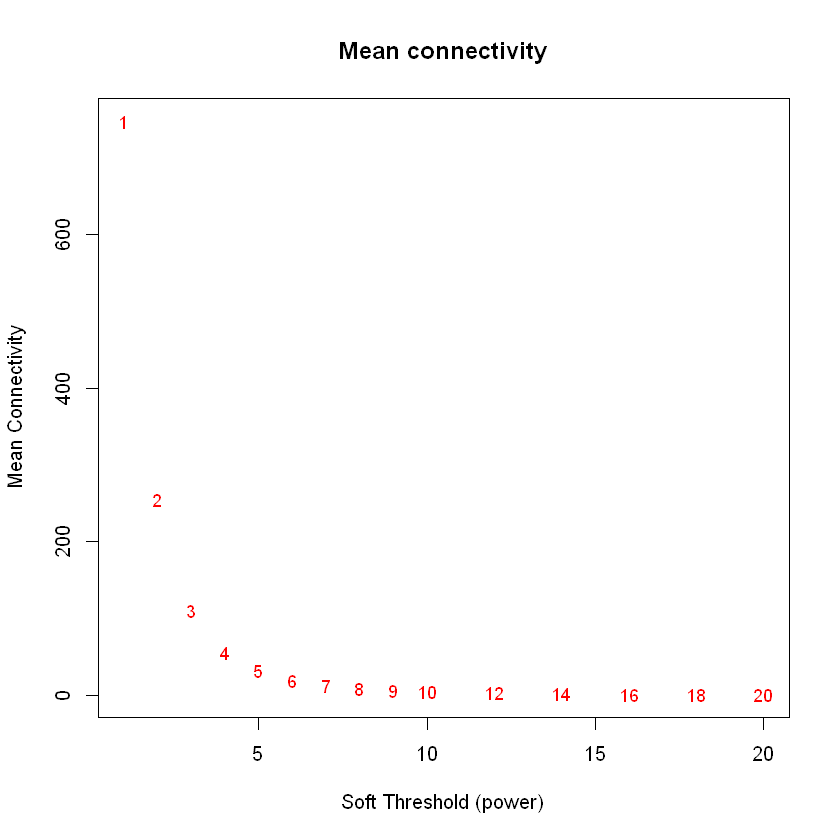

In [14]:
# Plot the results 结果绘图
# 设置窗格大小
#sizeGrWindow(9, 5)
# 设置图的显示一行两列
# par(mfrow = c(1,2));
cex1 = 0.9;
# Scale-free topology fit index as a function of the soft-thresholding power
# 生成阈值和网络的特征之间的关系函数
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

# sft$fitIndices 保存了每个power构建的相关性网络中的连接度的统计值，k就是连接度值，每个power值提供了max, median, max3种连接度的统计量
# 对连接度的均值进行可视化
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

#### 2.1.2 一步构建网络与模块检测  

确定好power值即可构建基因网络，构建基因网络和识别模块现在是一个简单的函数调用：

In [15]:
# datExpr表达数据，TOMType拓扑重叠矩阵计算方式，minModuleSize用于模块检测的最小模块尺寸,
# reassignThreshold 是否在模块之间重新分配基因的p值比率阈值，mergeCutHeight 树状图切割高度
# numericLabels 返回的模块应该用颜色（FALSE）还是数字（TRUE）标记,pamRespectsDendro树状图相关参数
# saveTOMs 字符串的向量，saveTOMFileBase 包含包含共识拓扑重叠文件的文件名库的字符串
net = blockwiseModules(datExpr, power = sft$powerEstimate,TOMType = "unsigned", minModuleSize = 30,reassignThreshold = 0, 
                       mergeCutHeight = 0.25,numericLabels = TRUE, pamRespectsDendro = FALSE,saveTOMs = TRUE,
                       saveTOMFileBase = "femaleMouseTOM",verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
Cluster size 3600 broken into 2108 1492 
Cluster size 2108 broken into 1126 982 
Done cluster 1126 
Done cluster 982 
Done cluster 2108 
Done cluster 1492 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.396405
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file femaleMouseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 7 because their KME is too low.
     ..removing 1 genes from module 8 because their KME is too low.
     ..removing 1 genes from module 21 because their KME is too low.
 ..merging modules that a

我们现在回到网络分析。要查看标识了多少个模块以及模块大小

In [16]:
 table(net$colors)


  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18 
 99 609 460 409 316 312 221 211 157 123 106 100  94  91  77  76  58  47  34 

指示有18个模块，按大小降序标记为1至18，大小范围为609至34个基因。 标签0保留用于所有模块外部的基因。 用于模块识别的分层聚类树状图（树）以net $ dendrograms [[1]]返回； 可以使用以下代码将树状图与颜色分配一起显示：

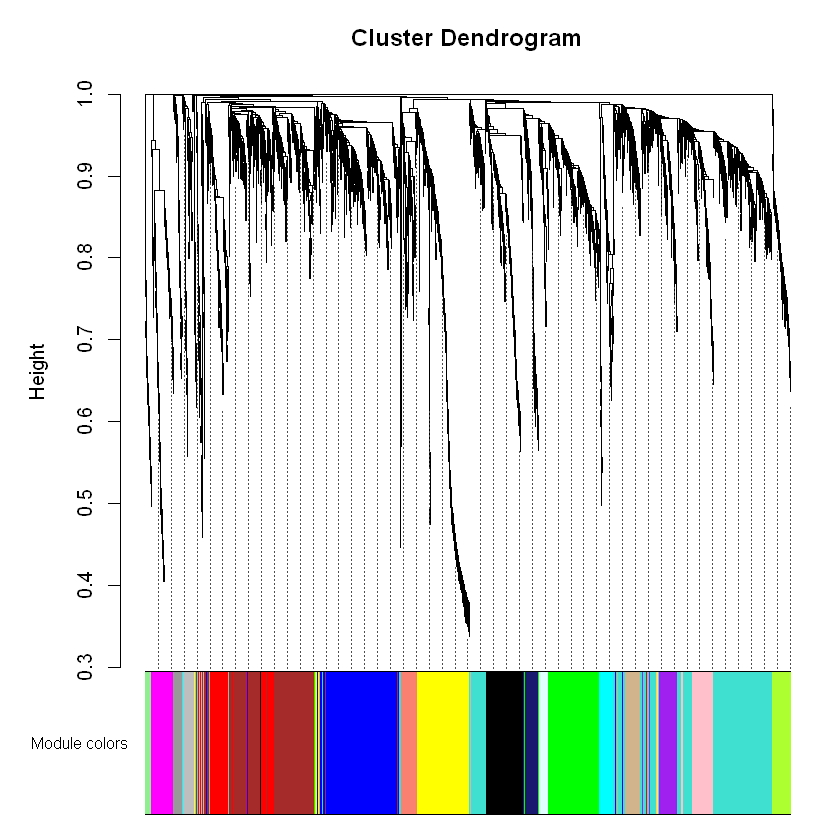

In [17]:
# open a graphics window
# sizeGrWindow(12, 9)
# Convert labels to colors for plotting
# 将标签转化为绘图颜色
mergedColors = labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
# 绘制树状图和下面的模块颜色
# dendroLabels树状图标签。设置为FALSE完全禁用树状图标签；设置为NULL使用的行标签datExpr
# addGuide是否应在树状图中添加垂直的“指导线”？线条使识别单个样本的颜色代码更加容易。
plotDendroAndColors(net$dendrograms[[1]], mergedColors[net$blockGenes[[1]]],"Module colors",
                    dendroLabels = FALSE, hang = 0.03,addGuide = TRUE, guideHang = 0.05)

结果图如上图所示。我们注意到，如果用户想更改条件，则该软件包提供了recutBlockwiseTrees函数，该函数可以应用修改后的条件而不必重新计算网络和聚类树状图。 这样可以节省大量时间。 现在，我们保存后续分析所需的模块分配和模块本征信息。

In [18]:
moduleLabels = net$colors
moduleColors = labels2colors(net$colors)
MEs = net$MEs;
geneTree = net$dendrograms[[1]];
save(MEs, moduleLabels, moduleColors, geneTree,
file = "FemaleLiver-02-networkConstruction-auto.RData")

### 2.2 其他检测算法  
其他算法包括分步网络构建和模块检测、处理大型数据集：逐块网络构建和模块检测就不再表述具体见下列链接：
> https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-man.pdf
> https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-blockwise.pdf

## 3 筛选与表型相关的模块
主要步骤如下：
1. 量化模块-特质关联
2. 基因与性状和重要模块的关系：基因重要性和模块成员
3. 模块内分析：鉴定具有高GS和MM的基因
4. 网络分析结果总结

### 3.1 量化模块-特质关联  
在此分析中，我们想确定与所测量的临床特征显着相关的模块。 由于我们已经为每个模块建立了一个概要文件（特征基因），因此我们只需将特征基因与外部特征相关联，然后寻找最重要的关联，实际上是计算模块的ME值与表型的相关系数：

In [19]:
# Define numbers of genes and samples
# 获得基因数和样本数
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);

# Recalculate MEs with color labels
# 用彩色标签重新计算MEs
# 在给定的单个数据集中计算模块的模块本征基因
MEs0 = moduleEigengenes(datExpr, moduleColors)$eigengenes
# 对给定的（特征）向量进行重新排序，以使相似的向量（通过相关性度量）彼此相邻
MEs = orderMEs(MEs0)

# 计算module的ME值与表型的相关系数
moduleTraitCor = cor(MEs, datTraits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

由于我们的模块和特征数量适中，因此合适的图形表示形式将有助于阅读表格。 我们通过相关值对每个关联进行颜色编码：

In [20]:
names(MEs)

[1] "MEmagenta"      "MEblack"        "MEturquoise"    "MEgreen"       
 [5] "MElightcyan"    "MEblue"         "MEbrown"        "MEred"         
 [9] "MEsalmon"       "MEyellow"       "MElightgreen"   "MEgreenyellow" 
[13] "MEgrey60"       "MEpink"         "MEpurple"       "MEtan"         
[17] "MEcyan"         "MEmidnightblue" "MEgrey"

Warning message in greenWhiteRed(50):
"WGCNA::greenWhiteRed: this palette is not suitable for people
with green-red color blindness (the most common kind of color blindness).
Consider using the function blueWhiteRed instead."

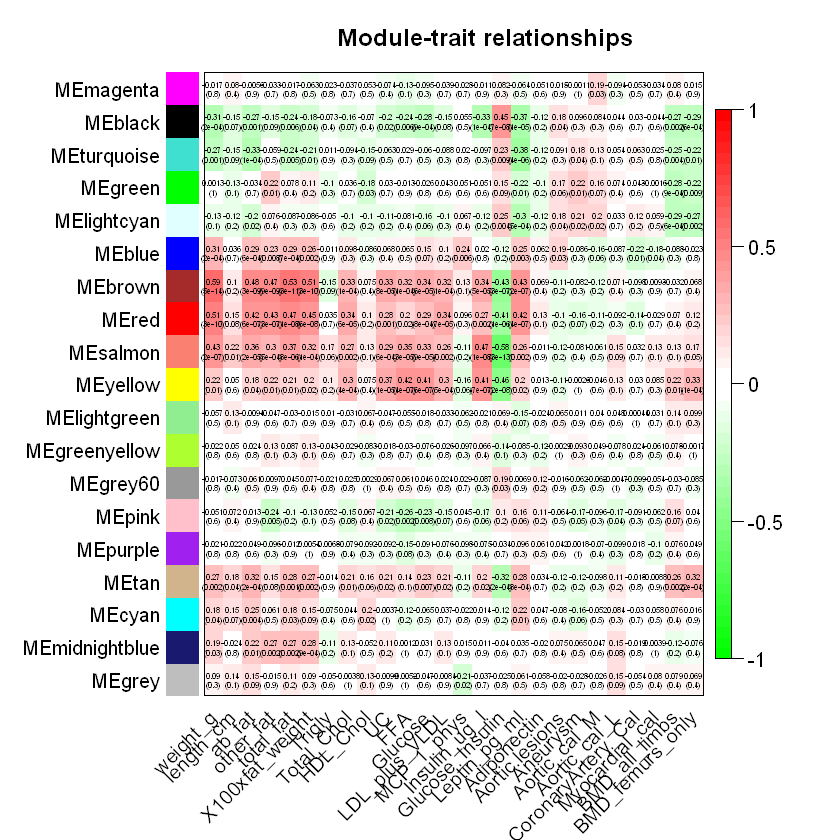

In [21]:
# sizeGrWindow(10,6)
# 显示相关性及其p值
textMatrix = paste(signif(moduleTraitCor, 2), "\n(",signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot\
# ySymbols 当ylabels使用时所使用的其他标签； colorLabels 应该使用颜色标签吗
# colors 颜色； textMatrix 单元格名字
labeledHeatmap(Matrix = moduleTraitCor,xLabels = names(datTraits),yLabels = names(MEs),ySymbols = names(MEs),
               colorLabels = FALSE,colors = greenWhiteRed(50),textMatrix = textMatrix,setStdMargins = FALSE,
               cex.text = 0.4,zlim = c(-1,1),
main = paste("Module-trait relationships"))

In [22]:
sizeGrWindow(10,6)
# Will display correlations and their p-values

dim(textMatrix) = dim(moduleTraitCor)
par(mar = c(6, 8.5, 3, 3));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
xLabels = names(datTraits),
yLabels = names(MEs),
ySymbols = names(MEs),
colorLabels = FALSE,
colors = greenWhiteRed(50),
textMatrix = textMatrix,
setStdMargins = FALSE,
cex.text = 0.5,
zlim = c(-1,1),
main = paste("Module-trait relationships"))

Warning message in greenWhiteRed(50):
"WGCNA::greenWhiteRed: this palette is not suitable for people
with green-red color blindness (the most common kind of color blindness).
Consider using the function blueWhiteRed instead."

### 3.2 基因与性状和重要模块的关系：基因重要性和模块成员  
我们量化阵列上所有基因与每个模块的相似性寻找重要模块

In [23]:
# Define variable weight containing the weight column of datTrait
# 定义包含数据特征权重列的变量权重
weight = as.data.frame(datTraits$weight_g);
names(weight) = "weight"
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"));
# 模块的名称(颜色) substring提取文本从第3个字母开始
modNames = substring(names(MEs), 3)
# 基因和模块的相关系数
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"));
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples));
names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");

#gene和性状的关系
geneTraitSignificance = as.data.frame(cor(datExpr, weight, use = "p"));
GSPvalue = as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples));
names(geneTraitSignificance) = paste("GS.", names(weight), sep="");
names(GSPvalue) = paste("p.GS.", names(weight), sep="");

### 3.3 模内分析：鉴定具有高GS和MM的基因

使用GS和MM度量，我们可以鉴定出对体重以及在感兴趣的模块中具有较高模块成员性具有重要意义的基因。 例如，我们看一下与重量关联最高的棕色模块。 我们在棕色模块中绘制了基因重要性与模块成员关系的散点图。 在此模块中，GS和MM之间存在高度显着的相关性。

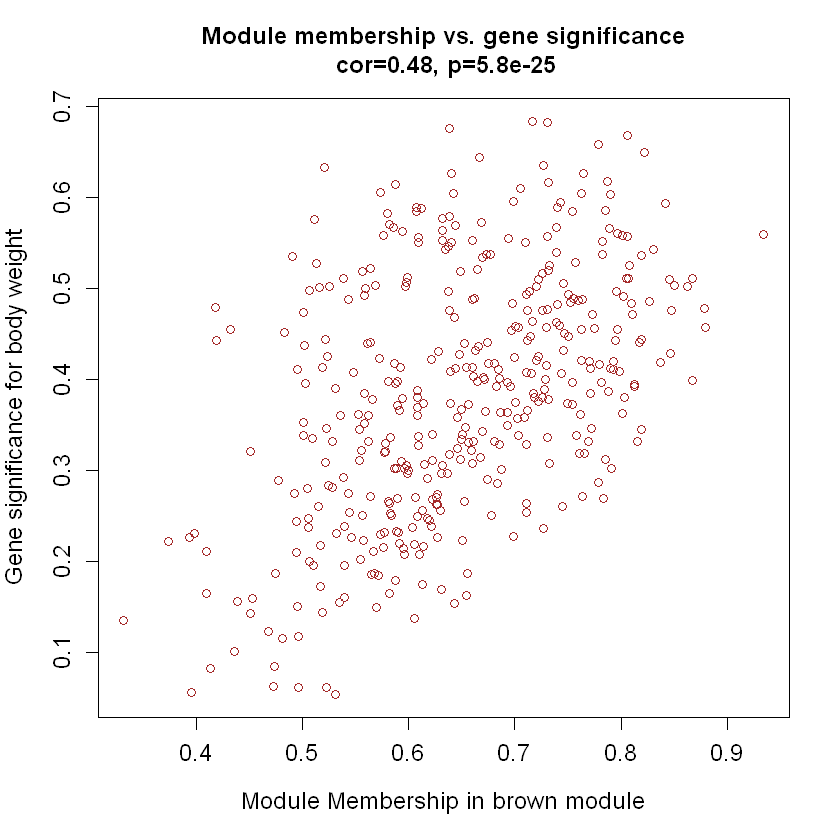

In [24]:
# 模型颜色
module = "brown"
# 匹配列
column = match(module, modNames);
moduleGenes = moduleColors==module;
#sizeGrWindow(7, 7);
par(mfrow = c(1,1));
# 画散点图
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                    abs(geneTraitSignificance[moduleGenes, 1]),
                    xlab = paste("Module Membership in", module, "module"),
                    ylab = "Gene significance for body weight",
                    main = paste("Module membership vs. gene significance\n"),
                    cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)

### 3.4 网络分析结果总结  
我们发现模块与我们的兴趣特征高度相关，并通过模块成员度量标准确定了其主要参与者。 现在，我们将此统计信息与基因注释合并，并写出一个文件，该文件总结了最重要的结果，并且可以在标准电子表格软件（例如MS Excel或Open Office Calc）中进行检查。 我们的表达式数据仅由探针ID名称注释：

In [25]:
# 提取表带数据样本名称
# names(datExpr);
# 指定颜色数据名称
# names(datExpr)[moduleColors=="brown"]

In [26]:
# 基因注释数据
annot = read.csv(file = "./data/GeneAnnotation.csv");
dim(annot)
names(annot)
probes = names(datExpr)
probes2annot = match(probes, annot$substanceBXH)
# The following is the number or probes without annotation:
sum(is.na(probes2annot))

[1] 23388    34

[1] "X"                        "ID"                      
 [3] "arrayname"                "substanceBXH"            
 [5] "gene_symbol"              "LocusLinkID"             
 [7] "OfficialGeneSymbol"       "OfficialGeneName"        
 [9] "LocusLinkSymbol"          "LocusLinkName"           
[11] "ProteomeShortDescription" "UnigeneCluster"          
[13] "LocusLinkCode"            "ProteomeID"              
[15] "ProteomeCode"             "SwissprotID"             
[17] "OMIMCode"                 "DirectedTilingPriority"  
[19] "AlternateSymbols"         "AlternateNames"          
[21] "SpeciesID"                "cytogeneticLoc"          
[23] "Organism"                 "clustername"             
[25] "reporterid"               "probeid"                 
[27] "sequenceid"               "clusterid"               
[29] "chromosome"               "startcoordinate"         
[31] "endcoordinate"            "strand"                  
[33] "sequence_3_to_5_prime"    "sequence_5_to_3_prime"

[1] 0

现在，我们创建一个数据框，其中包含所有探针的以下信息：探针ID，基因符号，基因座ID（Entrez码），模块颜色，重量的基因重要性以及模块中所有模块的成员和p值。 这些模块将按照其重量的重要性进行排序，而最重要的模块则位于左侧。

In [27]:
# Create the starting data frame
geneInfo0 = data.frame(substanceBXH = probes,
geneSymbol = annot$gene_symbol[probes2annot],
LocusLinkID = annot$LocusLinkID[probes2annot],
moduleColor = moduleColors,
geneTraitSignificance,
GSPvalue)
# Order modules by their significance for weight
modOrder = order(-abs(cor(MEs, weight, use = "p")));
# Add module membership information in the chosen order
for (mod in 1:ncol(geneModuleMembership))
{
    oldNames = names(geneInfo0)
    geneInfo0 = data.frame(geneInfo0, geneModuleMembership[, modOrder[mod]],
    MMPvalue[, modOrder[mod]]);
    names(geneInfo0) = c(oldNames, paste("MM.", modNames[modOrder[mod]], sep=""),
    paste("p.MM.", modNames[modOrder[mod]], sep=""))
}
# Order the genes in the geneInfo variable first by module color, then by geneTraitSignificance
geneOrder = order(geneInfo0$moduleColor, -abs(geneInfo0$GS.weight));
geneInfo = geneInfo0[geneOrder, ]
write.csv(geneInfo, file = "geneInfo.csv")

## 4 使用WGCNA进行网络可视化
主要步骤如下：
1. 显示基因网络
2. 可视化特征基因网络

## 4.1 显示基因网络  
可视化加权网络的一种方法是绘制其热图，热图的每一行和每一列都对应一个基因。 热图可以描述邻接或拓扑重叠，浅色表示低邻接（重叠），而深色表示更高的邻接（重叠）。 另外，沿着热图的顶部和左侧绘制了基因树状图和模块颜色。

TOM calculation: adjacency..
..will not use multithreading.
 Fraction of slow calculations: 0.396405
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


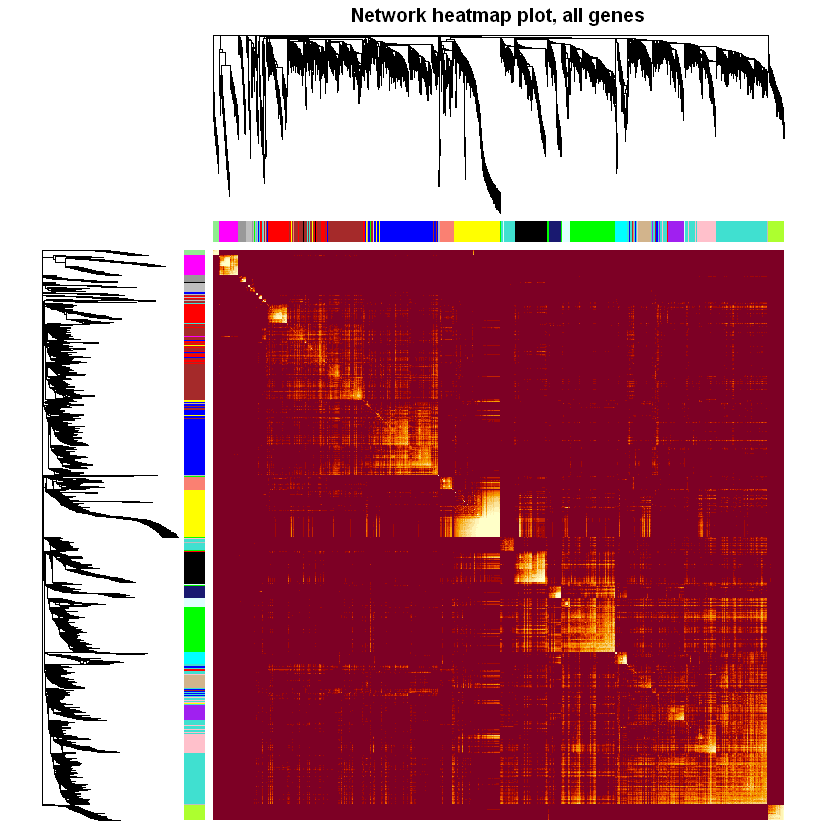

In [28]:
# Calculate topological overlap anew: this could be done more efficiently by saving the TOM
# calculated during module detection, but let us do it again here.
# 重新计算拓扑重叠：通过保存TOM可以更有效地完成此操作
# 是在模块检测期间计算的，但让我们在这里再次进行。
dissTOM = 1-TOMsimilarityFromExpr(datExpr, power = 6);
# Transform dissTOM with a power to make moderately strong connections more visible in the heatmap
# 变换dissTOM
plotTOM = dissTOM^7;
# Set diagonal to NA for a nicer plot
diag(plotTOM) = NA;
# Call the plot function
# sizeGrWindow(9,9)
# 基因的聚类树聚类时的距离为1-TOM值结合基因间的距离，即1-TOM值，用热图展示
# TOMplot(plotTOM, geneTree, moduleColors, main = "Network heatmap plot, all genes")

请注意，生成热图图可能要花费大量时间。 可以限制基因数量以加快绘图速度。 但是，一个基因子集的基因树状图通常看起来与所有基因的基因树状图不同。 在以下示例中，我们将绘制的基因数限制为400：

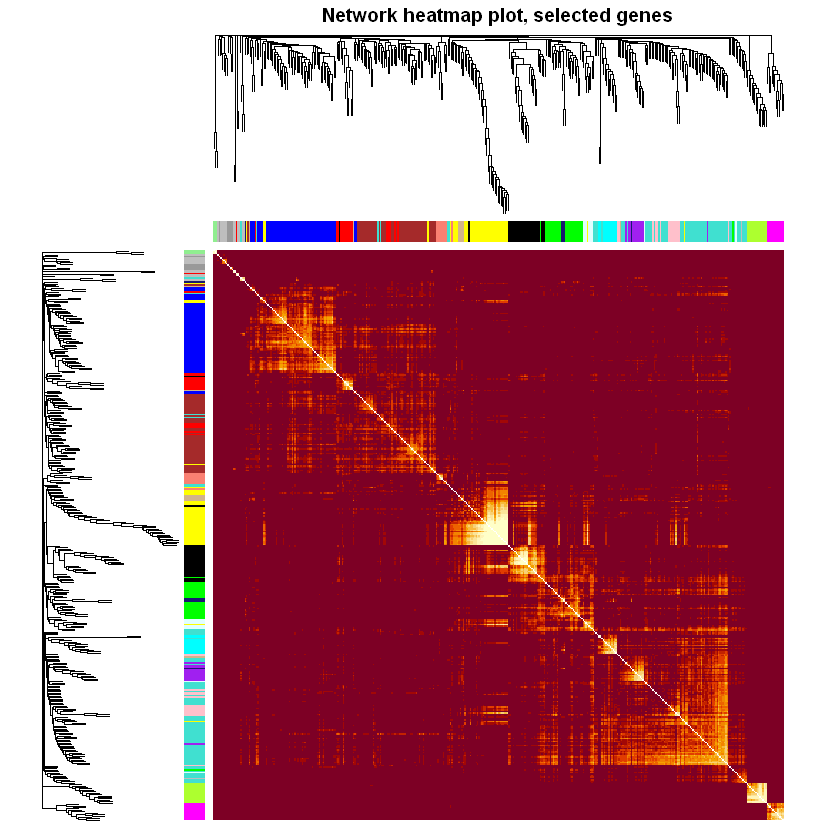

In [30]:
nSelect = 400
# For reproducibility, we set the random seed
set.seed(10);
select = sample(nGenes, size = nSelect);
selectTOM = dissTOM[select, select];
# There’s no simple way of restricting a clustering tree to a subset of genes, so we must re-cluster.
# 重新画聚类图
selectTree = hclust(as.dist(selectTOM), method = "average")
selectColors = moduleColors[select];
# Open a graphical window
# sizeGrWindow(9,9)
# Taking the dissimilarity to a power, say 10, makes the plot more informative by effectively changing
# the color palette; setting the diagonal to NA also improves the clarity of the plot
plotDiss = selectTOM^7;
diag(plotDiss) = NA;
TOMplot(plotDiss, selectTree, selectColors, main = "Network heatmap plot, selected genes")

### 4.2 可视化特征基因网络

研究找到的模块之间的关系通常很有趣。 可以使用特征基因作为代表特征，并通过特征基因相关性来量化模块相似性。 该软件包包含一个方便的函数plotEigengeneNetworks，该函数生成特征基因网络的摘要图。 通常，向特征基因添加临床特征（或多个特征）以了解特征如何适合特征基因网络是有益的

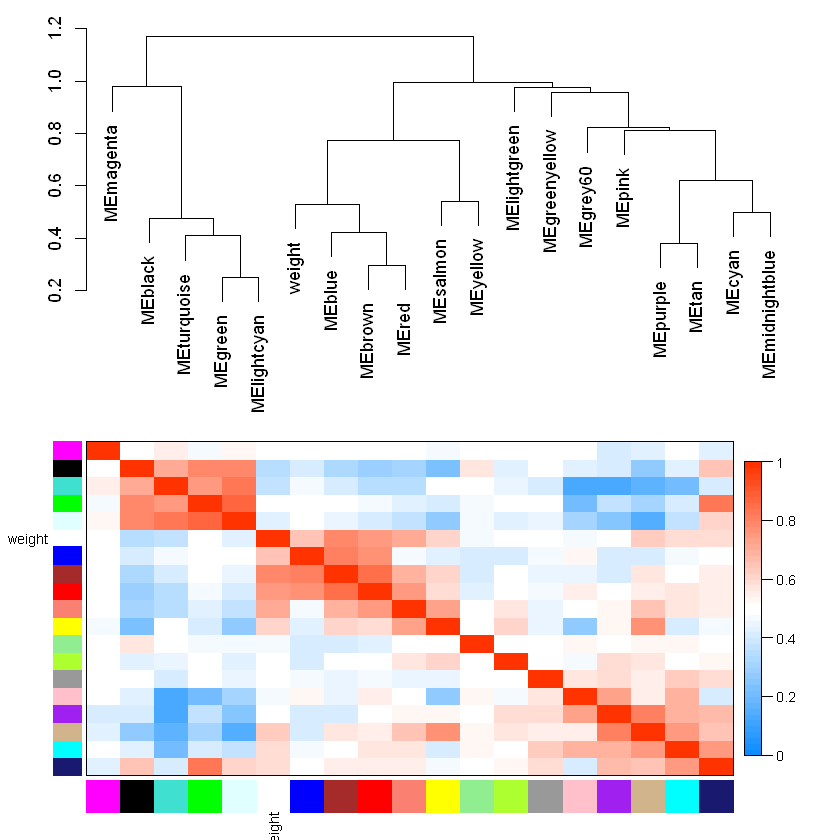

In [31]:
# Recalculate module eigengenes
# 重新计算基因特征值
MEs = moduleEigengenes(datExpr, moduleColors)$eigengenes
# Isolate weight from the clinical traits
weight = as.data.frame(datTraits$weight_g);
names(weight) = "weight"
# Add the weight to existing module eigengenes
MET = orderMEs(cbind(MEs, weight))
# Plot the relationships among the eigengenes and the trait
#sizeGrWindow(5,7.5);
par(cex = 0.9)
# 画树形图
# marDendro给出树状图的边距设置，marHeatmap热图边距设置
plotEigengeneNetworks(MET, "", marDendro = c(0,4,1,2), marHeatmap = c(3,4,1,2), cex.lab = 0.8, xLabelsAngle= 90)

该函数生成特征基因和特征的树状图，以及它们之间关系的热图。 要拆分树状图和热图图，我们可以使用以下代码

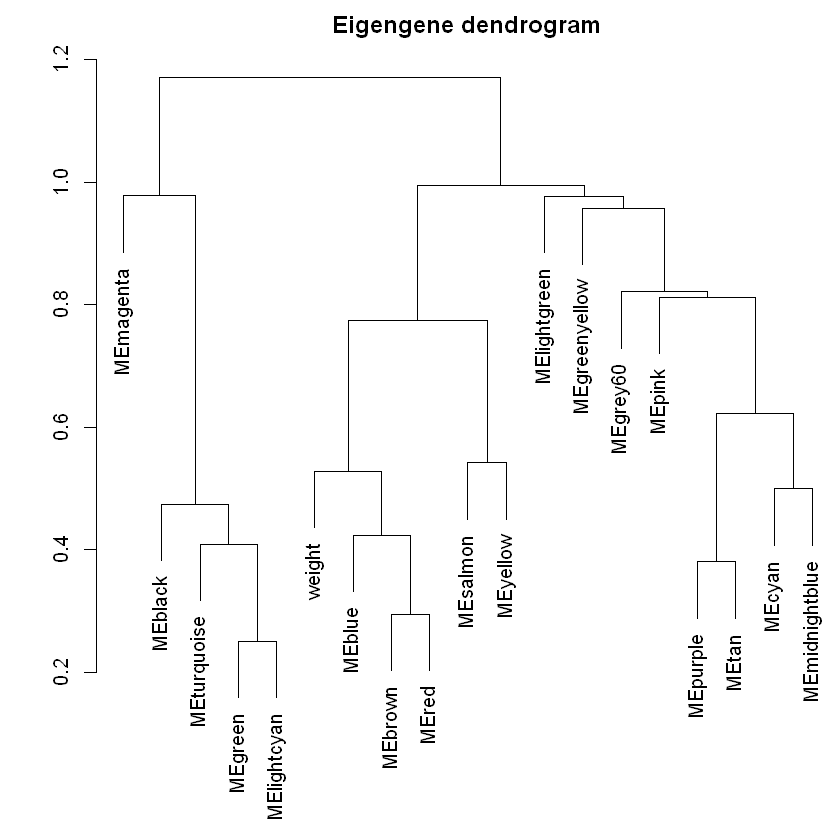

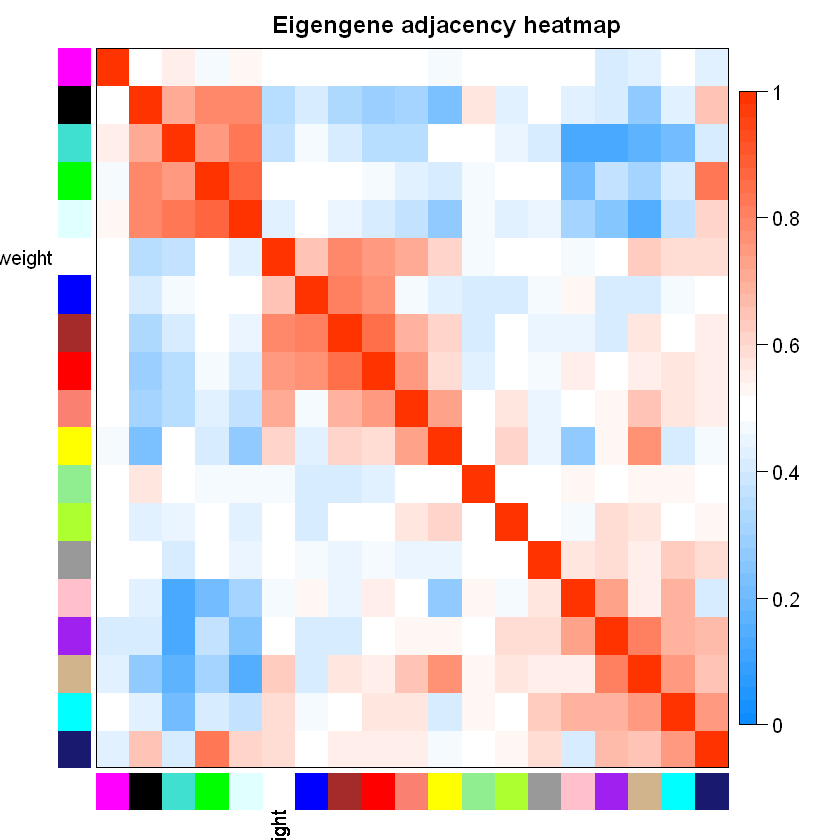

In [33]:
# Plot the dendrogram
# sizeGrWindow(6,6);
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
plotHeatmaps = FALSE)
# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(3,4,2,2),plotDendrograms = FALSE, xLabelsAngle = 90)

上图为上述代码的输出。本征基因树状图和热图识别了被称为元模块的相关本征基因群。例如，树状图表明，红、棕、蓝三个模块具有高度的相关性，它们之间的相互关系强于它们与体重的相关性。

## 5 参考

> https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/  
> https://www.jianshu.com/p/e9cc3f43441d  
> https://blog.csdn.net/weixin_43569478/article/details/83747303  
> https://www.jianshu.com/p/25905a905086